# Katsiaryna Zaitsava, 11714999

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage import data, io, filters, exposure
import cv2

### 1. Image Enhacement

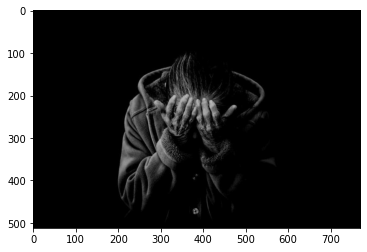

In [2]:
skeleton_im = imread('kegelapan.jpg')
# Set color map to grayscale
plt.set_cmap(plt.cm.gray)

# Original build
plt.imshow(skeleton_im)

For all the transformations except one I have used scikit-image library. For the smoothing filter I applied function from cv2 library.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gamma corrected (0.4)')

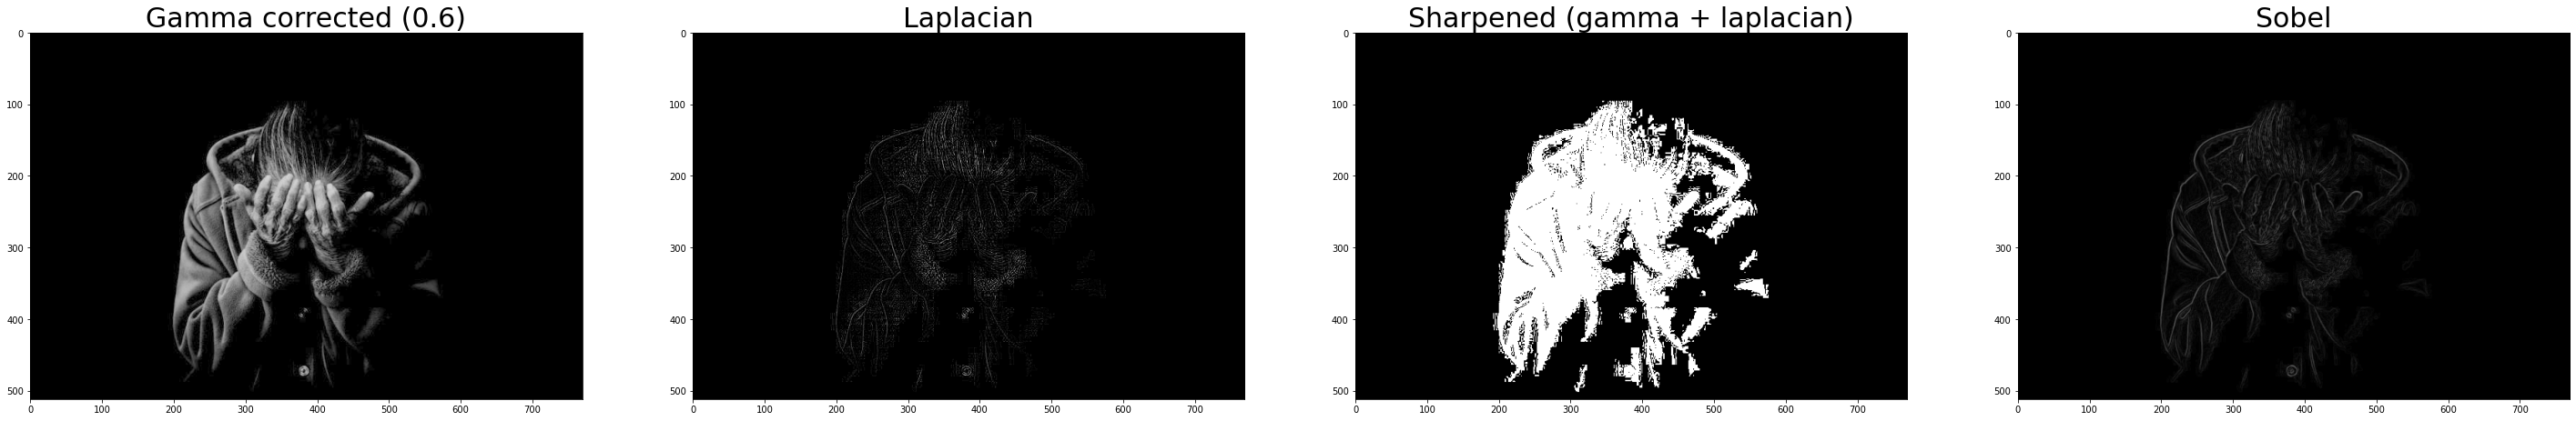

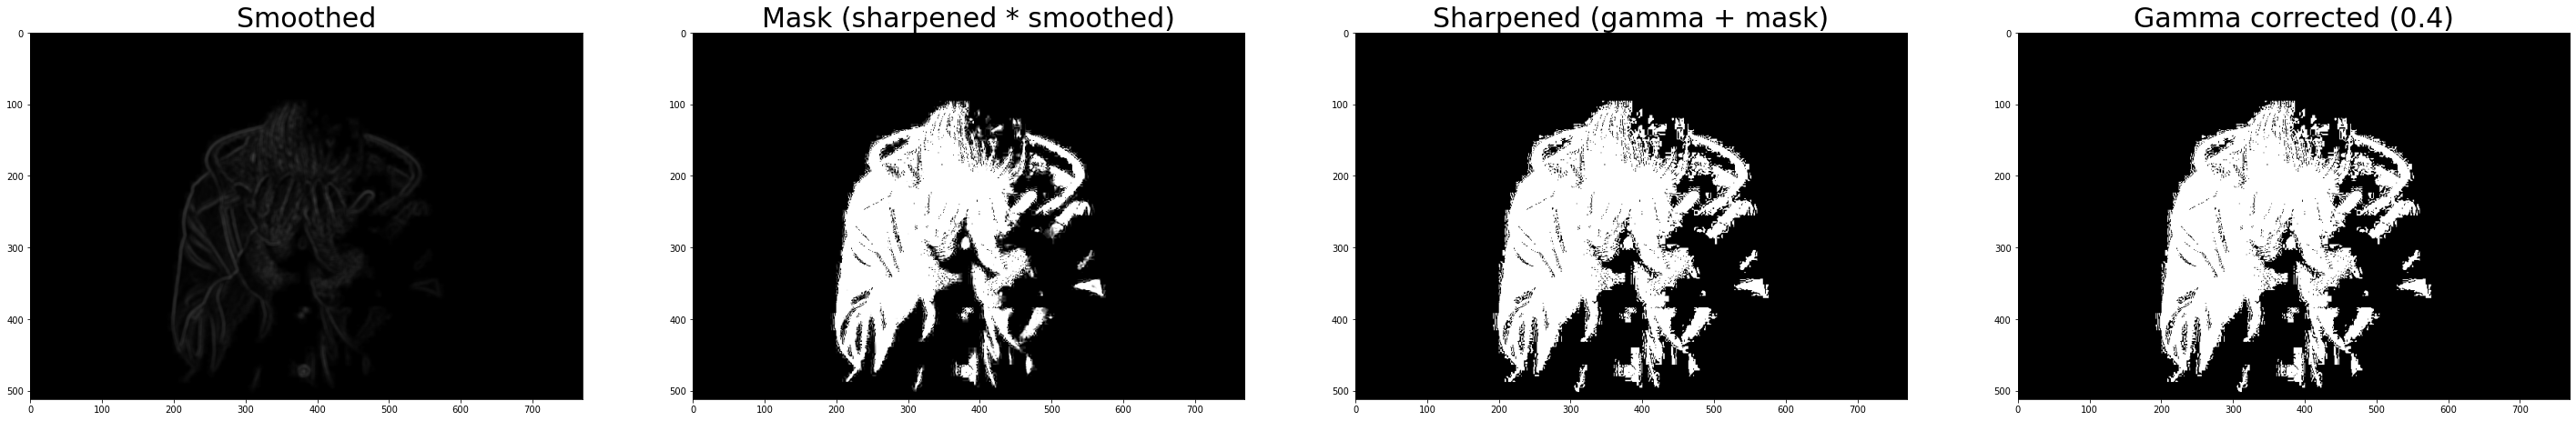

In [3]:
# Gamma correction by a factor of 0.6
gamma = exposure.adjust_gamma(skeleton_im, 0.6)  

# Laplacian of gamma corrected image
laplace = filters.laplace(gamma)

# Sharpened image (gamma + laplacian)
sharpened = gamma + laplace

# Sobel gradient of gamma corrected image
sobel = filters.sobel(gamma)

# Smoothed sobel imgage
kernel = np.ones((5, 5), np.float32) / 25
smoothed = cv2.filter2D(sobel, -1, kernel)

# Mask image (sharpened * smoothed)
mask = sharpened * smoothed

# Sharpened image (gamma + mask)
sharpened_2 = gamma + mask

# Gamma filter is not working with negative values so I convert all the negative ones to 0. 
sharpened_2[sharpened_2 < 0] = 0

# Final gamma correction by a factor of 0.4
gamma_2 = exposure.adjust_gamma(sharpened_2, 0.6)

# Output of results
fig1, ax1 = plt.subplots(1, 4, figsize = (50, 100))

ax1[0].imshow(gamma)
ax1[1].imshow(laplace)
ax1[2].imshow(sharpened)
ax1[3].imshow(sobel)
ax1[0].set_title("Gamma corrected (0.6)", size = 30)
ax1[1].set_title("Laplacian", size = 30)
ax1[2].set_title("Sharpened (gamma + laplacian)", size = 30)
ax1[3].set_title("Sobel", size = 30)

fig2, ax2 = plt.subplots(1, 4, figsize = (50, 100))
ax2[0].imshow(smoothed)
ax2[1].imshow(mask)
ax2[2].imshow(sharpened_2)
ax2[3].imshow(gamma_2)
ax2[0].set_title("Smoothed", size = 30)
ax2[1].set_title("Mask (sharpened * smoothed)", size = 30)
ax2[2].set_title("Sharpened (gamma + mask)", size = 30)
ax2[3].set_title("Gamma corrected (0.4)", size = 30)




### 2. Convolution

I have multiplied two vectors (transposed x and y), got a matrix and noticed, that the sums of the elements along the  diagonals parallel to the side diagonal give the result of convolution.
So if x = [x1, x2, x3] and y = [y1, y2] than x.T * y will give the matrix as follows:


[[x1y1, x1y2] <br>
 [x2y1, x2y2] <br>
 [x3y1, x3y2]]
 
The following vector resulting from adding the elements of matrix along the diagonals parallel to the side diagonal give the result of convolution:
 
 [x1y1, x2y1+x1y2, x3y1+x2y2, x3y2]
 
I found this fact quite interesting (maybe not the easiest one to implement though) and so this is what my implementation of convolution function based on.


In [4]:
# Two dictionaries are parameters of my function conv1(). Keys are indices, 
def conv1(x, y):
    
    # Separete keys (indices) and values of dictionaries
    keys_x = np.fromiter(x.keys(), dtype=float)
    vals_x = np.array([np.fromiter(x.values(), dtype=float)])
    keys_y = np.fromiter(y.keys(), dtype=float)
    vals_y = np.array([np.fromiter(y.values(), dtype=float)])
    
    #matrix of multiplied values of vectors
    matrix = np.dot(vals_x.T, vals_y)
    
    # Initialize the start index with the sum of two indices
    index = keys_x[0] + keys_y[0]
    result = {}

    # Let matrix be of the size MxN. 
    # The sum of the coefficients of elements in each diagonal is same starting from 0 at the top left corner till 
    # (M+N-2) at the bottom right corner.
    for value in range(len(matrix) + len(matrix[0]) - 1):
        tmp = 0;
    # To the temporary sum I add only those values of matrix, whose indices do not go beyond matrix number of rows and columns
    # Index increases by 1 at each iteration 
        for i in range(value + 1):
            if i < len(matrix) and (value - i) < len(matrix[0]):
                tmp += matrix[i, value - i]
        result[index] = tmp
        index += 1
    return result


x = {-1: 1, 0: 2, 1: 3}
y = {-1: 1, 0: -1}

convolution = conv1(x, y)


<StemContainer object of 3 artists>

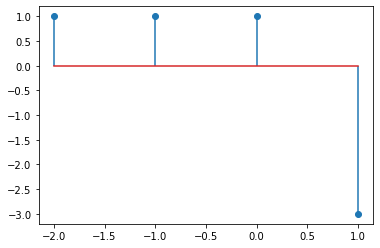

In [5]:
plt.stem(np.fromiter(convolution.keys(), dtype=float), np.fromiter(convolution.values(), dtype=float))

### 3. LTI Systems

a) Calculate impulse response of the system

Convolution of input function and impulse response gives the output function: y[n] = x[n] * h[n] (' * ' is for convolutional sum)<br>
We have the input function (x[n] = {-1: 1, 0:2, 1:1} ) and the output function (y[n] = {-3:0, -2:-1, -1:-2, 0:0, 1:2, 2:1} ) in the task.
So I will manualy go through all the steps of convolution to find the corresponding indices of impulse response.


1. First input unit impuls is at the index -1 and has value 1. In the first convolution step it is multiplied with the value x at index i. The result is value -1 at the index -2. <br>
1 * x = -1 -> x = -1 <br>
-1 + i = -2 -> i = -1

Start index found, further the index with each iteration will decrease by 1 (because the impulse response is a reversed).

<StemContainer object of 3 artists>

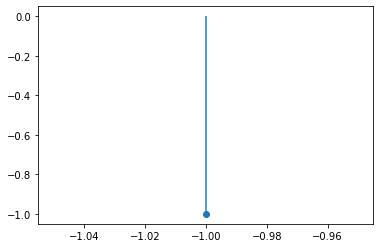

In [6]:
plt.stem([ -1], [-1])

Further I will right down only the formulas needed to calculate the steps and show each step on the stem-plot.<br><br>
2. <br>x*1 + 2 * (-1) = -2 -> x = 0 <br>
   i = -2

<StemContainer object of 3 artists>

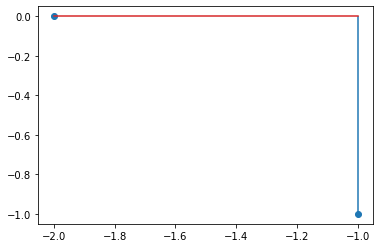

In [7]:
plt.stem([-2, -1], [0, -1])

3.<br> x * 1 + 0 * 2 + 1 * (-1) = 0 -> x = 1 <br> i = -3

<StemContainer object of 3 artists>

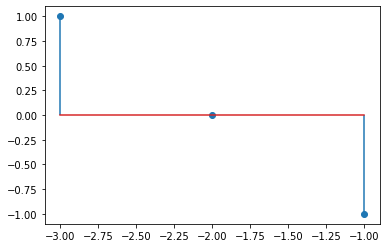

In [8]:
plt.stem([ -3, -2, -1], [1, 0, -1])

4. <br> x * 1 + 1 * 2 + 0 * 1 = 2 -> x = 0 <br> i = -4

<StemContainer object of 3 artists>

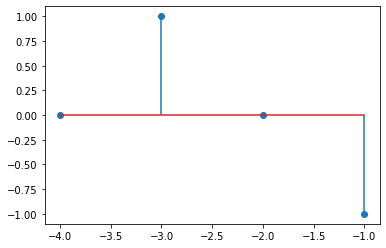

In [9]:
plt.stem([-4, -3, -2, -1], [ 0, 1, 0, -1])

5. <br> x * 1 + 2 * 0 + 1 * 1 = 1 -> x = 0 <br> i = -5 <br><br> 
All the values of the output signal are viewed. All other values of the impulse response except values at the positions -1 and 1 are equal to 0.<br>
Impulse response needs to be reflected horizontaly relative to the right edge -> the impulse response looks as follows (all the zero values on the edges I disregard):

<StemContainer object of 3 artists>

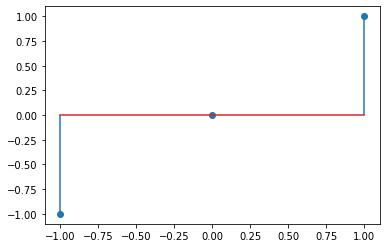

In [10]:
plt.stem([ -1, 0, 1], [ -1, 0, 1])

b) Determine the response to the input

In [11]:
h = {-1: -1, 0: 0, 1: 1}
x1 = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 3, 6: 2, 7: 1, 8: 0}

response = conv1(x1, h)

<StemContainer object of 3 artists>

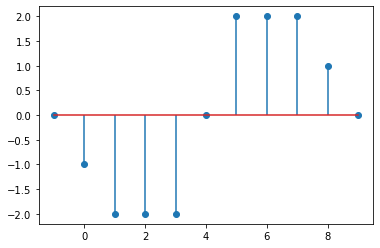

In [12]:
plt.stem(np.fromiter(response.keys(), dtype=float), np.fromiter(response.values(), dtype=float))

### 4. 2D Discrete Fourier Transform

For this task I have used formulas 4-86, 4-87, 4-88 from Gonzalez & Woods book and built-in functions from numpy library

In [13]:
# Original images
rectangle_im = imread('kegelapan.jpg')
woman_im = imread('kegelapan.jpg')

In [14]:
# Calculated FFT of the woman image
woman_fft = np.fft.fft2(woman_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Woman spectrum + Rectangle phase')

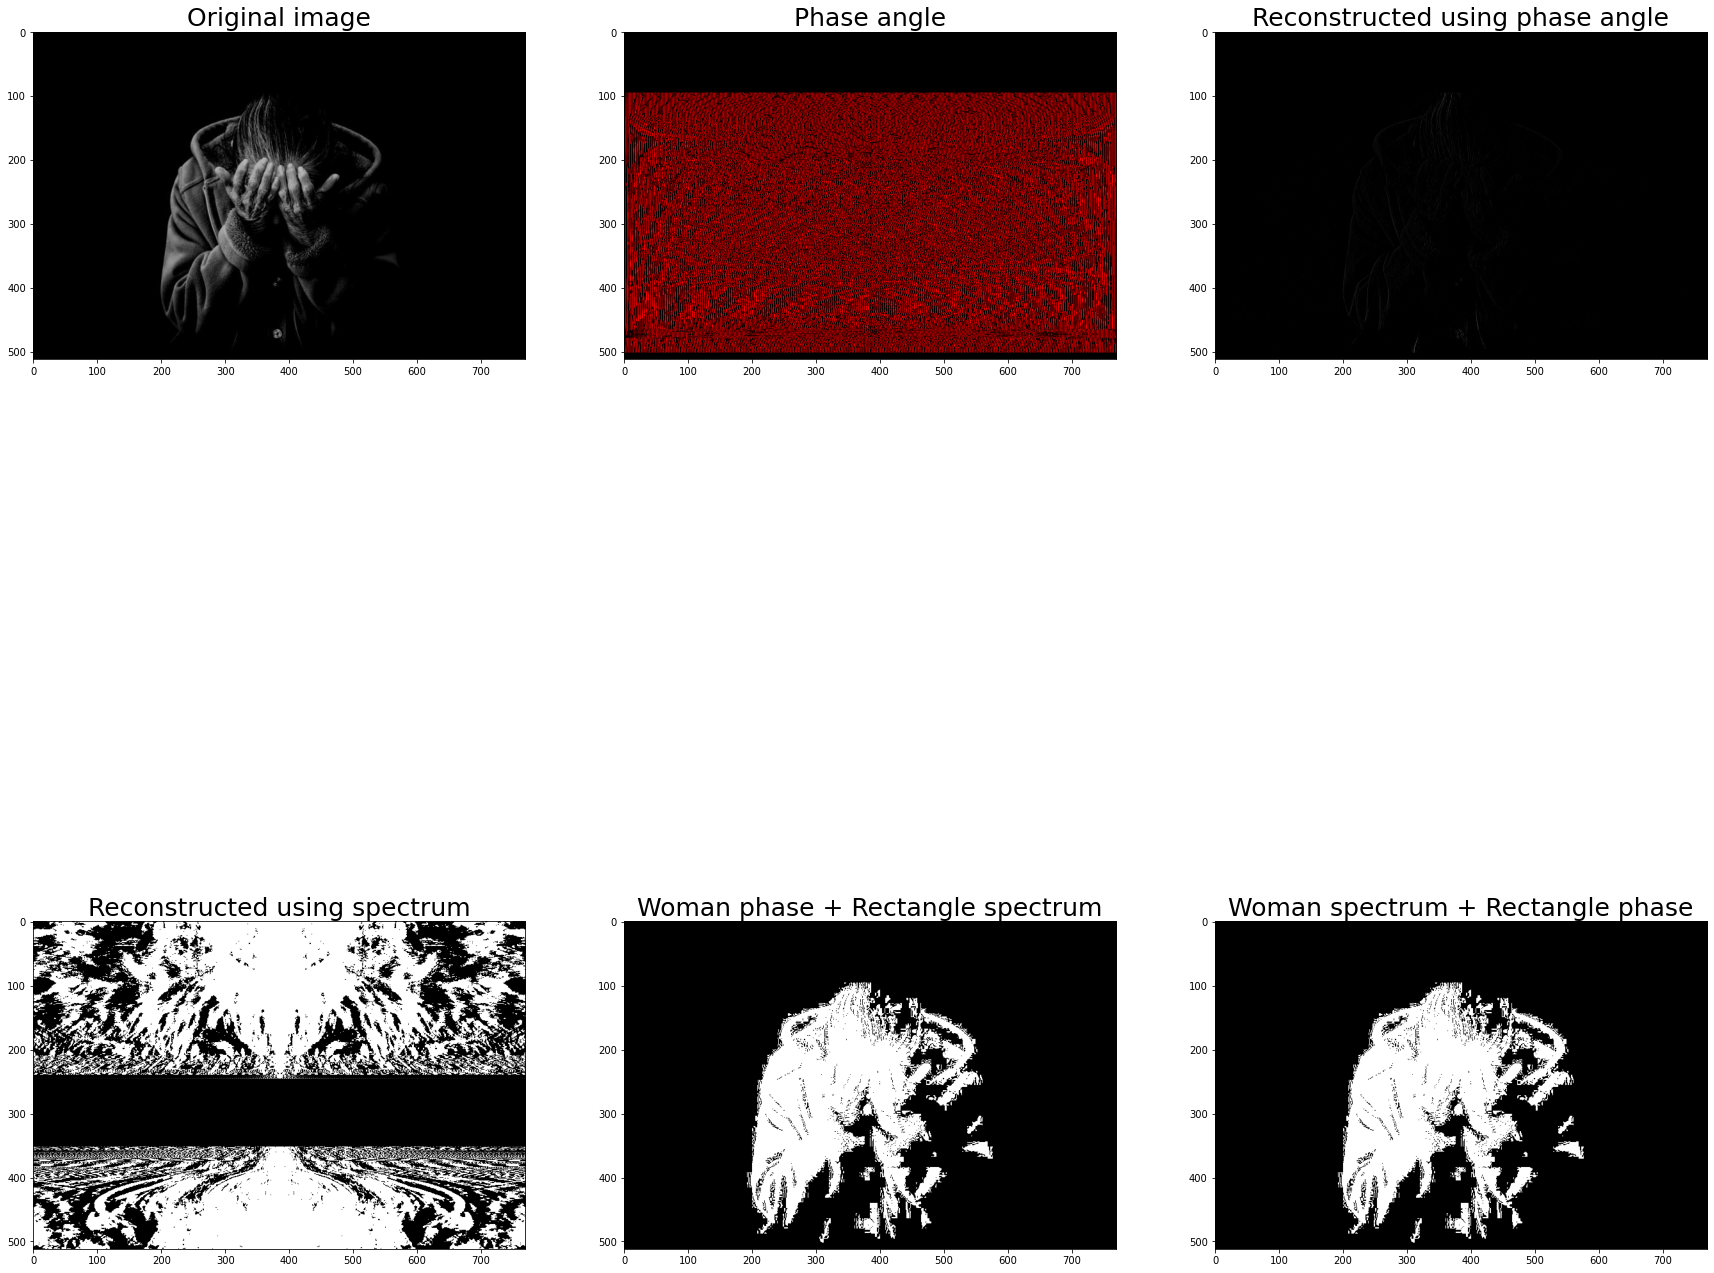

In [15]:
# Calculated phase angle
woman_phase = np.arctan2(woman_fft.imag, woman_fft.real)

# Reconstructed image using only phase angle
woman_exp = np.exp(1j * woman_phase)
reconstructed_phase = np.fft.ifft2(woman_exp).real

# Calculated spectrum
woman_spectrum = np.abs(woman_fft)


# Reconstructed image using only spectrum
reconstructed_spectrum = np.fft.fftshift(np.fft.ifft2(woman_spectrum)).real
# Remove all negative values
reconstructed_spectrum = reconstructed_spectrum.clip(min = 0)
#Enhanced image using gamma transformation in spatial domain
enhanced_spectrum = 255 * (reconstructed_spectrum / 255) ** 0.45

# Calculated FFT of the rectangle image
rectangle_fft = np.fft.fft2(rectangle_im)

# Rectangle phase angle
rectangle_phase = np.arctan2(rectangle_fft.imag, rectangle_fft.real)

# Rectangle spectrum
rectangle_spectrum = np.abs(rectangle_fft)

# Reconstructed image using spectrum of the rectangle and phase angle of the woman 
rec_rspectrum_wphase = np.fft.ifft2(rectangle_spectrum * woman_exp).real

# Reconstructed image using spectrum of the woman and phase angle of the rectangle
rectangle_exp = woman_exp = np.exp(1j * rectangle_phase)
rec_wspectrum_rphase = np.fft.ifft2(woman_spectrum * rectangle_exp).real

# Plotting
fig4, ax4 = plt.subplots(2, 3, figsize = (30, 30))
ax4[0,0].imshow(woman_im)
ax4[0,1].imshow(woman_phase)
ax4[0,2].imshow(reconstructed_phase)
ax4[1,0].imshow(enhanced_spectrum)
ax4[1,1].imshow(rec_rspectrum_wphase)
ax4[1,2].imshow(rec_wspectrum_rphase)

ax4[0,0].set_title("Original image", size = 25)
ax4[0,1].set_title("Phase angle", size = 25)
ax4[0,2].set_title("Reconstructed using phase angle", size = 25)
ax4[1,0].set_title("Reconstructed using spectrum", size = 25)
ax4[1,1].set_title("Woman phase + Rectangle spectrum", size = 25)
ax4[1,2].set_title("Woman spectrum + Rectangle phase", size = 25)



### 5. Image Enhancement in Frequency Domain

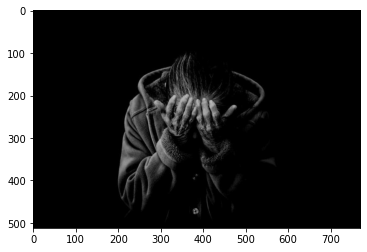

In [16]:
# Import original image of the moon
blurry_moon = imread('kegelapan.jpg')
plt.imshow(blurry_moon)

For the calculation of the Gaussian Lowpass Filter I used 'Summary of steps for filtering in the frequency domain' form Gonzalez & Woods book as suggested.

Step 1: Calculate size PxQ of padded image

In [17]:
P = blurry_moon.shape[0] * 2
Q = blurry_moon.shape[1] * 2

Step 2: Form a padded image of size P x Q. I used zero-padding. 
The original image is placed at the top left corner, everywhere else are zeros. 
This type of padding gives though a dark border but for this task it is irrelevant, because original picture is dark 
around the edges.

In [18]:
padded_moon = np.zeros((P, Q))
padded_moon[0:blurry_moon.shape[0], 0:blurry_moon.shape[1]] = blurry_moon
plt.imshow(padded_moon)

ValueError: could not broadcast input array from shape (512,770,3) into shape (512,770)

Step 3: Multiply padded image by (-1)^(x+y) to center the Fourier transform on the P x Q frequency rectangle

In [ ]:
for x in range (padded_moon.shape[0]):
    for y in range (padded_moon.shape[1]):
        padded_moon[x,y] *= (-1)**(x+y)
plt.imshow(padded_moon)

Step 4: DFT of image from step 3

In [ ]:
moon_fft = np.fft.fft2(padded_moon)

Step 5: Compute real, symmetric, filter transfer function H(u,v) of size P x Q with center at (P/2, Q/2).
Function H(u, v) is Gaussian Lowpass Filter in this case (formula 4-116 from Gonzalez & Woods book) <br>
H(u, v) = e ^ (-D^2(u, v)/ 2*D0)

In [ ]:
D = np.zeros((P, Q))

In [ ]:
p_centered = P//2
q_centered = Q//2
for u in range (moon_fft.shape[0]):
    for v in range (moon_fft.shape[1]):
        D[u,v] = - (u - p_centered)**2 - (v - q_centered)**2
D0 = 1000
H = np.exp(D/(2*D0))
# Gaussian frequency filter
plt.imshow(H)

Step 6: Form the product G(u,v) = H(u, v) F(u, v)

In [ ]:
G = H * moon_fft

Step 7: Obtain image by computing IDFT of G(u, v)

In [ ]:
blurred = np.fft.ifft2(G).real
for x in range (blurred.shape[0]):
    for y in range (blurred.shape[1]):
        blurred[x,y] *= (-1)**(x+y)
plt.imshow(blurred)

Step 8: Obtain the final filtered result of the same size as the input image by extracting M x N region from the top, left

In [ ]:
blurred_cropped = blurred[0:blurry_moon.shape[0], 0:blurry_moon.shape[1]]
plt.imshow(blurred_cropped)

To calculate unsharp mask I substract resulting blurred image from the original one (Formula 3-64 Gonzalez & Woods)

In [ ]:
unsharp_mask = blurry_moon - blurred_cropped
plt.imshow(unsharp_mask)

For calculation of the enchanced image with the unsharp masking applied I use the formula 3-65 form Gonzalez & Woods book and set k = 1.

In [ ]:
enhanced_unsharp_mask = unsharp_mask + blurry_moon
plt.imshow(enhanced_unsharp_mask)

When k > 1 in the formula mentioned above than the process is reffered to as highboos filtering.

In [ ]:
highboost = 2 * unsharp_mask + blurry_moon
plt.imshow(highboost)

In [ ]:
fig5, ax5 = plt.subplots(2, 3, figsize = (50, 50))
ax5[0,0].imshow(blurry_moon)
ax5[0,1].imshow(H)
ax5[0,2].imshow(blurred_cropped)
ax5[1,0].imshow(unsharp_mask)
ax5[1,1].imshow(enhanced_unsharp_mask)
ax5[1,2].imshow(highboost)

ax5[0,0].set_title("The original image", size=25)
ax5[0,1].set_title("The Gaussian frequency filter", size=25)
ax5[0,2].set_title("The blurred image", size=25)
ax5[1,0].set_title("The unsharp mask", size=25)
ax5[1,1].set_title("Unsharp masking applied", size=25)
ax5[1,2].set_title("High-boost filter applied", size=25)

# Downloaded images are of the better quality (not that gray) and the enhancemant can be better seen

In [ ]:
cv2.imwrite('highboost.png', highboost)
cv2.imwrite('unsharp.png', enhanced_unsharp_mask)
cv2.imwrite('maks.png', unsharp_mask)